# Reverse time migration (RTM)

In [1]:
%reset -f

In [2]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, interpolate

import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files
env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/RTM/wrk/


## Load and plot marmousi 

In [3]:
dir_model = "./model/"
dir_seis  = "./seis/"
ox, oz = 0.0, 0.0
dx, dz = 1.0, 1.0
x1, x2 = 0.0, 550.0
z1, z2 = 0.0, 900.0


x_grid = np.arange(x1, x2 + dx, dx)
z_grid = np.arange(z1, z2 + dz, dz)
nx, nz = x_grid.size, z_grid.size
print("Grid dimensions: ", nx, nz)
model_sampling = (dx, dz)

model_padding = (100,100)
### Read (dx, dz) = (2, 2) model
vp2d_true = np.fromfile(dir_model+"vp2d_true.bin", dtype="float32")
vp2d_init = np.fromfile(dir_model+"vp2d_init.bin", dtype="float32")

vp2d_true = vp2d_true.reshape(nx,nz)
vp2d_init = vp2d_init.reshape(nx,nz)

Grid dimensions:  551 901


In [4]:
# ---- Receiver geometry ----
drec = 1.0
recz1 = 1.0
recz2 =884
recx1 = 200.0
recz = np.arange(recz1, recz2, drec)
recx = np.full(recz.shape, recx1)
recs = np.column_stack([recx, recz])

# ---- Source geometry ----
srcx = np.array([182.3])
srcz = np.full(srcx.shape, 1.0)
srcs = np.column_stack([srcx, srcz])


# Sampling in the x and z directions (5m for both in this case)
model_sampling = (dx, dz)
# Origin of the model (0, 0)
model_origins = (ox, oz)


In [5]:
recs.shape

(883, 2)

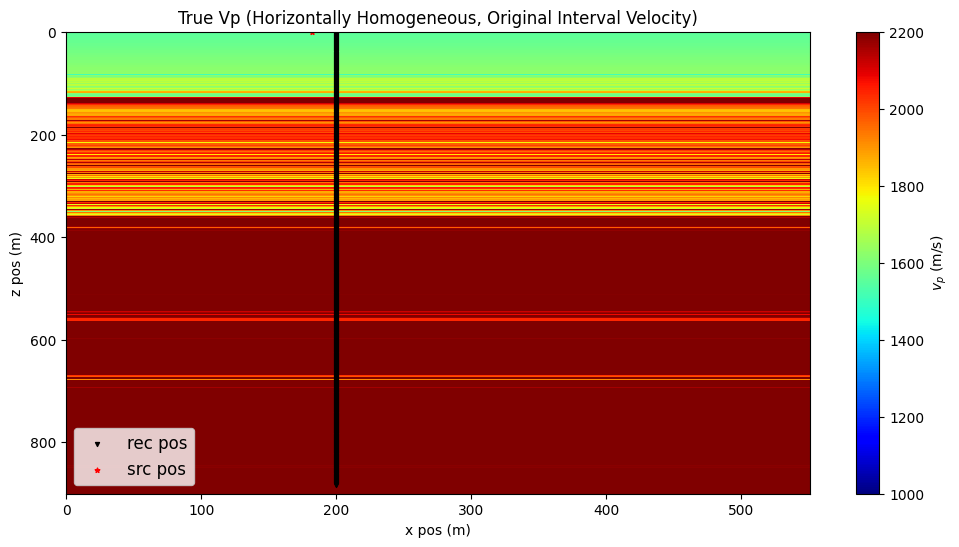

In [6]:
# ---- Plot ----
plotting.plot_model(
    vp2d_true,
    title="True Vp (Horizontally Homogeneous, Original Interval Velocity)",
    cbar=True,
    sampling=(dx, dz),
    origins=(ox, oz),
    cmap='jet',
    cbar_label='$v_p$ (m/s)',
    src_locations=srcs,
    rec_locations=recs,
    figsize=(12, 6),
    vlims=[1000, 2200]
)



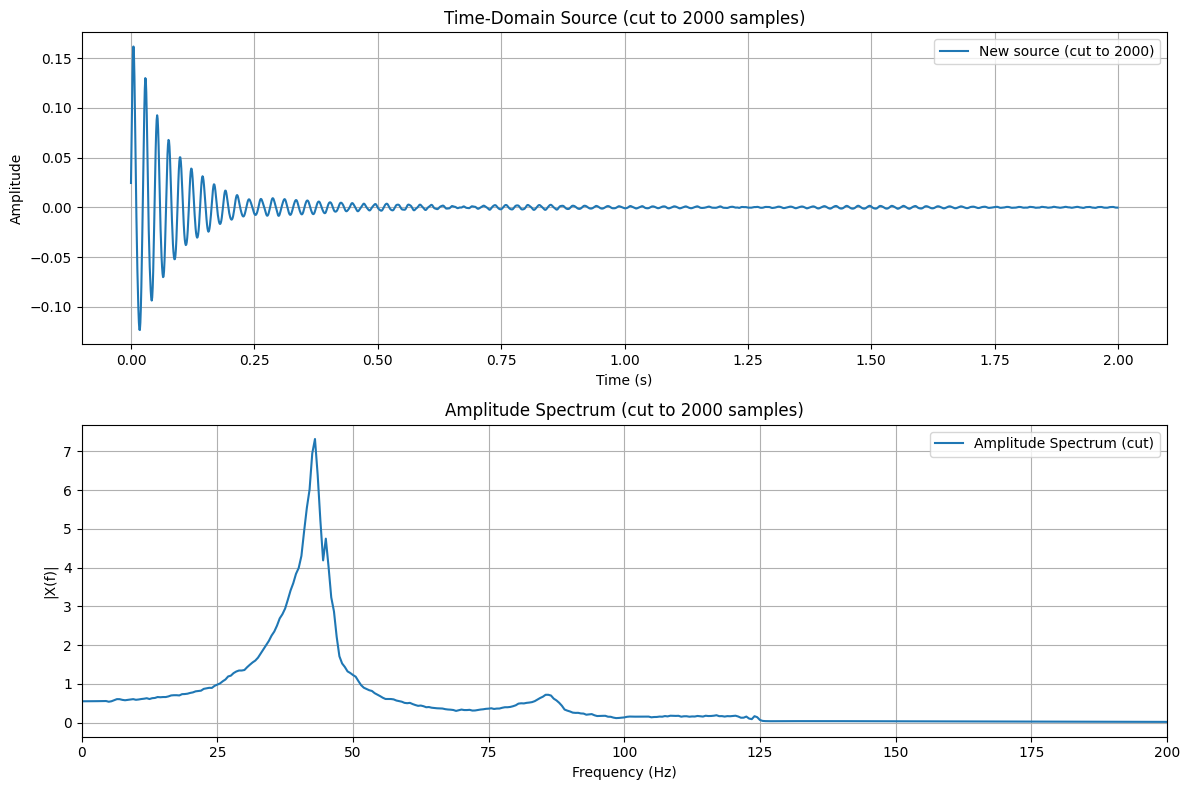

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------- params --------
file_path1 = "source_pilot_run3_raw.bin"
nt = 3001       # original samples
dt = 0.001
nt_new = 2000   # <--- cut down to 2000 samples

# -------- load raw --------
data1 = np.fromfile(file_path1, dtype=np.float32).astype(np.float64, copy=False)
if len(data1) < nt:
    raise ValueError(f"File has {len(data1)} samples, but nt={nt} requested.")
data1_raw = data1[:nt_new]   # <--- keep only 2000 samples

# time axis
time_axis = np.arange(nt_new) * dt

# -------- use AS-IS (cut to nt_new) --------
new_source = data1_raw.copy()

# -------- spectrum helper --------
def one_sided_spectrum(x, dt):
    X = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), d=dt)
    return f, np.abs(X)

f_src, A_src = one_sided_spectrum(new_source, dt)

# -------- the source function form --------
# similar style, but here it's just truncated (no padding needed)
source_form = np.pad(data1_raw, (0, nt_new - len(data1_raw)), mode="constant")

# -------- plots --------
plt.figure(figsize=(12, 8))

# Time-domain (cut)
plt.subplot(2, 1, 1)
plt.plot(time_axis, new_source, label='New source (cut to 2000)')
plt.title("Time-Domain Source (cut to 2000 samples)")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.grid(True); plt.legend()

# Spectrum (cut)
plt.subplot(2, 1, 2)
plt.plot(f_src, A_src, label='Amplitude Spectrum (cut)')
plt.title("Amplitude Spectrum (cut to 2000 samples)")
plt.xlabel("Frequency (Hz)"); plt.ylabel("|X(f)|")
plt.xlim(0, 200); plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# simple NaN fill (vertical interpolation + neighbor copy)
def clean_velocity(v, v_floor=500.0):
    v = np.array(v, copy=True)
    nz, nx = v.shape
    z = np.arange(nz)
    for ix in range(nx):
        col = v[:, ix]
        m = np.isfinite(col)
        if m.any():
            v[:, ix] = np.interp(z, z[m], col[m])
        else:
            # copy from nearest valid column
            j = min([k for k in range(nx) if np.isfinite(v[:,k]).any()],
                    key=lambda k: abs(k-ix))
            v[:, ix] = v[:, j]
    return np.clip(v, v_floor, None).astype(np.float32)

vp2d_true = clean_velocity(vp2d_true)

## Initialize acoustic wave equation

In [9]:
# make 2d elastic wave equation solver
acoustic_2d_obs_base = acoustic_isotropic.AcousticIsotropic2D(
    model=vp2d_true,
    model_sampling=model_sampling,
    model_padding=model_padding,
    wavelet=source_form,
    d_t=dt,
    src_locations=srcs,
    rec_locations=recs,
    model_origins=model_origins,
    subsampling=20,
    gpus=[0])

## Make observed data

In [10]:
%%time
data_obs_base_p = acoustic_2d_obs_base.forward(vp2d_true)

CPU times: user 8.54 s, sys: 2.86 s, total: 11.4 s
Wall time: 2.65 s


In [11]:
%%time
data_cal_base_p = acoustic_2d_obs_base.forward(vp2d_init)

CPU times: user 7.17 s, sys: 1.88 s, total: 9.05 s
Wall time: 2.17 s


## Make migration velocity model

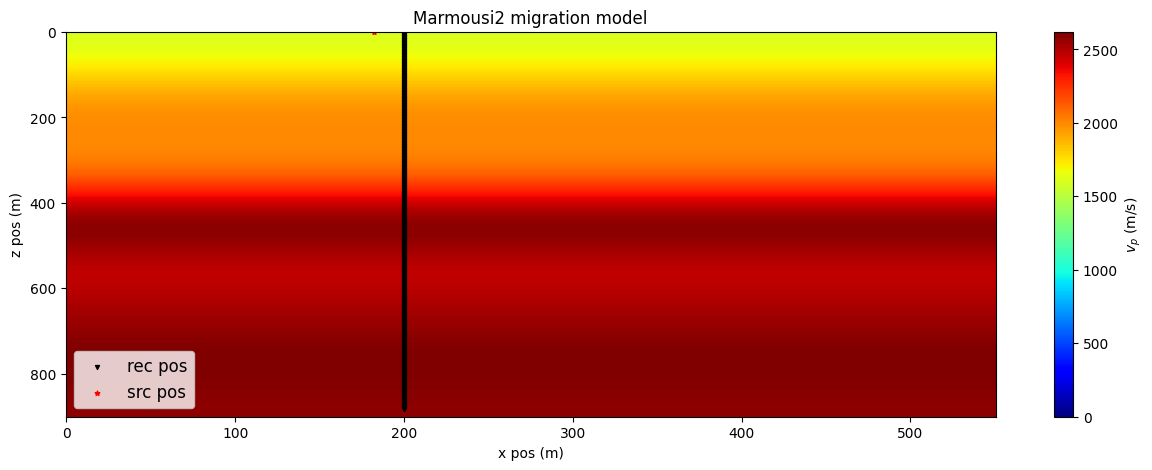

In [12]:
# mig_model = ndimage.gaussian_filter(vp2d_true,sigma=(20,20))
mig_model = ndimage.gaussian_filter(vp2d_true,sigma=(60,60))

plotting.plot_model(mig_model,
           title='Marmousi2 migration model', 
           cbar=True,
           sampling=model_sampling,
           origins=model_origins,
           src_locations=srcs,
           rec_locations=recs)

In [13]:
data_obs_base_p.shape

(1, 883, 2000)

## loaded the raw data

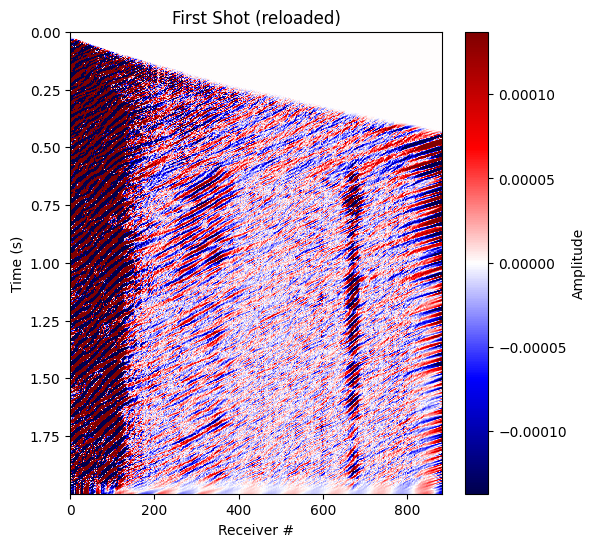

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# dimensions
nr, nt = 883, 2000
dt = 0.001  # sample interval [s]

# reload the binary file
shot0 = np.fromfile("./data/rtm_input_upgoing_FBmuted.bin", dtype=np.float32).reshape(nr, nt)

# build axes
time_axis = np.arange(nt) * dt
rec_axis = np.arange(nr)

# robust scaling for colormap
vmax = np.percentile(np.abs(shot0), 85)   # you can adjust 85 -> 90/95
vmin = -vmax

# plot
plt.figure(figsize=(6, 6))
plt.pcolormesh(rec_axis, time_axis, shot0.T,
               shading='nearest', cmap='seismic',
               vmin=vmin, vmax=vmax)
plt.gca().invert_yaxis()
plt.title("First Shot (reloaded)")
plt.xlabel("Receiver #")
plt.ylabel("Time (s)")
plt.colorbar(label="Amplitude")
plt.show()


In [15]:
shot0.shape

(883, 2000)

In [16]:
data_obs_base_p.shape

(1, 883, 2000)

In [17]:
# extend to 3D to fit with RTM process
shot0_cut_3d = shot0[np.newaxis, :, :]   # (1, 446, 2000)

In [18]:
shot0_cut_3d.shape

(1, 883, 2000)

# Test for loaded RTM result

In [41]:
%%time

img_base_TS_R = acoustic_2d_obs_base.jacobian_adjoint(shot0_cut_3d, mig_model)


CPU times: user 15 s, sys: 4.62 s, total: 19.7 s
Wall time: 6.77 s


In [42]:
img_base_TS_R.shape

(551, 901)

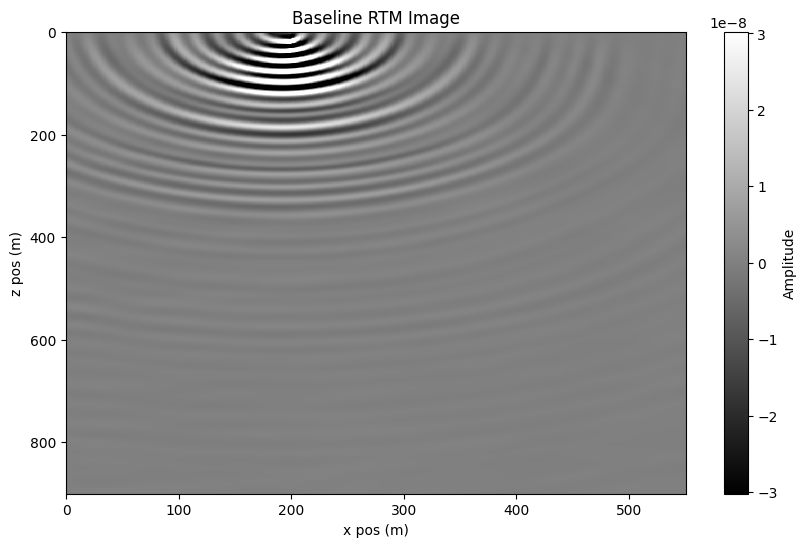

In [43]:
clip = np.percentile(abs(img_base_TS_R),99)
plotting.plot_model(img_base_TS_R,
                    title='Baseline RTM Image', 
                    sampling=model_sampling,
                    origins=model_origins,
                    cbar=True,
                    cmap='gray',
                    cbar_label='Amplitude',
                    figsize=(10,6),
                    vlims=[-clip,clip])

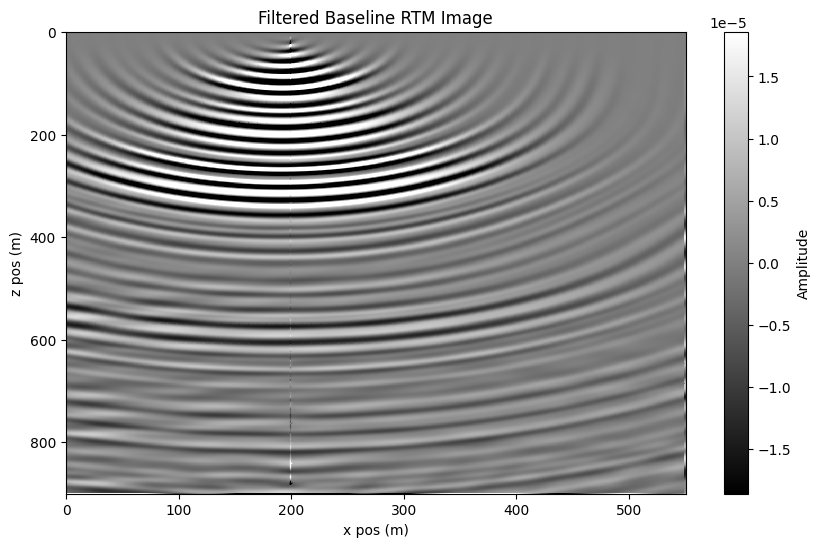

In [44]:
filtered_img_base1 = np.arange(img_base_TS_R.shape[-1])**2 * ndimage.laplace(img_base_TS_R)

clip = np.percentile(abs(filtered_img_base1),95)
plotting.plot_model(filtered_img_base1,
           title='Filtered Baseline RTM Image', 
           sampling=model_sampling,
           origins=model_origins,
           cmap='gray',
           cbar=True,
           cbar_label='Amplitude',
           figsize=(10,6),
           vlims=[-clip,clip])


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define the angle
dzdx = math.tan(math.radians(0.0))

# Reservoir 1 (top )
restop1_x = np.array([100, 400])   # X-coordinates for reservoir 1 top
restop1_z = np.array([124, 124]) # Z-coordinates for reservoir 1 top (same depth)


# Reservoir 2 (top)
restop2_x = np.array([100, 400])  # X-coordinates for reservoir 2 top
restop2_z = np.array([361, 361])   # Z-coordinates for reservoir 2 top (same depth)

# Reservoir 3 (top)
restop3_x = np.array([100, 400])  # X-coordinates for reservoir 3 top
restop3_z = np.array([400, 400])   # Z-coordinates for reservoir 3 top (same depth)

# Reservoir 4 (top)
restop4_x = np.array([100, 400])  # X-coordinates for reservoir 4 top
restop4_z = np.array([499, 499])   # Z-coordinates for reservoir 4 top (same depth)

# Reservoir 5 (top)
restop5_x = np.array([100, 400])  # X-coordinates for reservoir 5 top
restop5_z = np.array([560, 560])   # Z-coordinates for reservoir 5 top (same depth)

# Reservoir 6 (top)
restop6_x = np.array([100, 400])  # X-coordinates for reservoir 6 top
restop6_z = np.array([592, 592])   # Z-coordinates for reservoir 6 top (same depth)

# Reservoir 7 (top)
restop7_x = np.array([100, 400])  # X-coordinates for reservoir 7 top
restop7_z = np.array([671, 671])   # Z-coordinates for reservoir 7 top (same depth)

# Create arrays for the lines (reservoir 1)
line_restop1 = np.array([restop1_x, restop1_z]).T

line_restop2 = np.array([restop2_x, restop2_z]).T

line_restop3 = np.array([restop3_x, restop3_z]).T

line_restop4 = np.array([restop4_x, restop4_z]).T

line_restop5 = np.array([restop5_x, restop5_z]).T

line_restop6 = np.array([restop6_x, restop6_z]).T

line_restop7 = np.array([restop7_x, restop7_z]).T



No handles with labels found to put in legend.


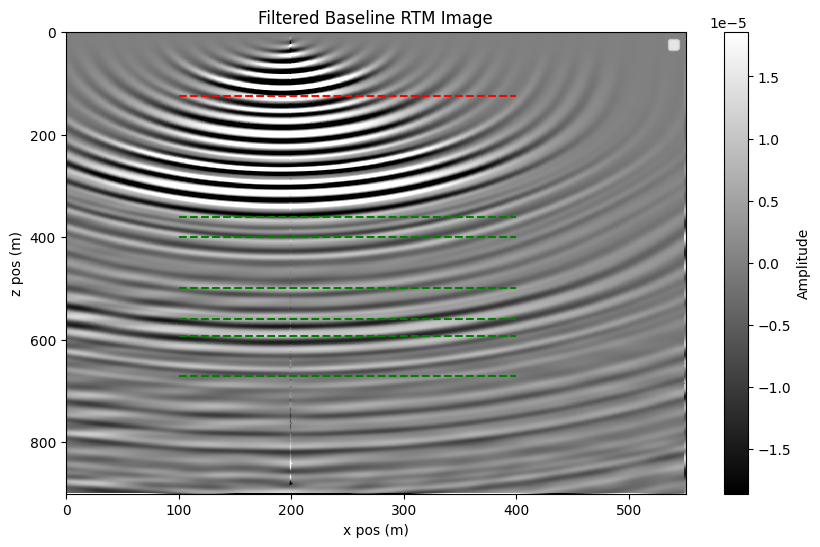

In [46]:
filtered_img_base1 = np.arange(img_base_TS_R.shape[-1])**2 * ndimage.laplace(img_base_TS_R)

clip = np.percentile(abs(filtered_img_base1),95)
plotting.plot_model(filtered_img_base1,
           title='Filtered Baseline RTM Image', 
           sampling=model_sampling,
           origins=model_origins,
           cmap='gray',
           cbar=True,
           cbar_label='Amplitude',
           figsize=(10,6),
           vlims=[-clip,clip])




# Add lines for Reservoir 1
plt.plot(line_restop1[:, 0], line_restop1[:, 1], 'r--')  # Red solid line for top of Reservoir 1
plt.plot(line_restop2[:, 0], line_restop2[:, 1], 'g--')  # Green solid line for top of Reservoir 2
plt.plot(line_restop3[:, 0], line_restop3[:, 1], 'g--')  # Green solid line for top of Reservoir 2

plt.plot(line_restop4[:, 0], line_restop4[:, 1], 'g--')  # Green solid line for top of Reservoir 2

plt.plot(line_restop5[:, 0], line_restop5[:, 1], 'g--')  # Green solid line for top of Reservoir 2

plt.plot(line_restop6[:, 0], line_restop6[:, 1], 'g--')  # Green solid line for top of Reservoir 2

plt.plot(line_restop7[:, 0], line_restop7[:, 1], 'g--')  # Green solid line for top of Reservoir 2

# Add lines for Reservoir 2
# plt.plot(line_restop2[:, 0], line_restop2[:, 1], 'g-', label="Reservoir 2 Top")  # Green solid line for top of Reservoir 2
# plt.plot(line_resbtm2[:, 0], line_resbtm2[:, 1], 'y-', label="Reservoir 2 Bottom")  # Yellow solid line for bottom of Reservoir 2

# Add labels, legends, etc.
plt.legend()
plt.show()